In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import pytz

import astroplan
from astroplan import Observer, FixedTarget, ObservingBlock, SequentialScheduler, Transitioner

from astroplan import plots
color_cycle = plots.mplstyles.astropy_mpl_style['axes.color_cycle']

In [3]:
pal = Observer.at_site('Palomar', timezone=pytz.timezone('US/Pacific'))
pal

<Observer: name='Palomar',
    location (lon, lat, el)=(-116.863 deg, 33.356 deg, 1706.0 m),
    timezone=<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>>

In [4]:
midnight = pal.midnight(Time('2015-11-03 5:00'))
midnight

<Time object: scale='utc' format='jd' value=2457329.81305>

In [5]:
targets = [FixedTarget.from_name('Vega'),
           FixedTarget.from_name('Deneb'),
           FixedTarget.from_name('Altair'),
           FixedTarget.from_name('Albireo')]
targets

[<FixedTarget "Vega" at SkyCoord (ICRS): (ra, dec) in deg (279.23473479, 38.78368896)>,
 <FixedTarget "Deneb" at SkyCoord (ICRS): (ra, dec) in deg (310.35797975, 45.28033881)>,
 <FixedTarget "Altair" at SkyCoord (ICRS): (ra, dec) in deg (297.6958273, 8.8683212)>,
 <FixedTarget "Albireo" at SkyCoord (ICRS): (ra, dec) in deg (292.68033548, 27.95968007)>]

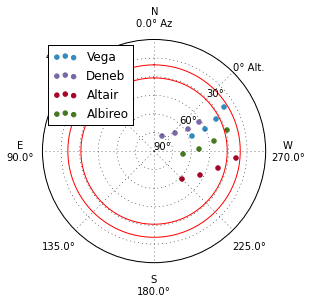

In [6]:
t1 = pal.twilight_evening_astronomical(midnight)
ts = t1 + [0, 1, 2, 3]*u.hour
for target, c in zip(targets, color_cycle):
    plots.plot_sky(target, pal, ts, style_kwargs=dict(color=c))
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/2))]*100, color='r')
plt.plot(np.linspace(0,2*np.pi,100), [np.degrees(np.arccos(1/3))]*100, color='r')
plt.legend(loc='upper left')

In [7]:
etime = 5*u.min
n = 10
rot = 55*u.second

blocks = [ObservingBlock.from_exposures(t, etime, n, rot) for t in targets]

In [8]:
blocks

[<astroplan.scheduling.ObservingBlock (Vega, unscheduled) at 0x111af4090>,
 <astroplan.scheduling.ObservingBlock (Deneb, unscheduled) at 0x110680c90>,
 <astroplan.scheduling.ObservingBlock (Altair, unscheduled) at 0x110681b50>,
 <astroplan.scheduling.ObservingBlock (Albireo, unscheduled) at 0x111733ed0>]

In [9]:
constraints = [astroplan.constraints.AirmassConstraint(3, boolean_constraint=False),
               astroplan.constraints.AtNightConstraint(18*u.deg)
               #,astroplan.constraints.MoonSeparationConstraint(5*u.deg)
               ]
trans = Transitioner(slew_rate=1*u.deg/u.second)

In [10]:
start_time = pal.twilight_evening_astronomical(midnight)
end_time = pal.twilight_morning_astronomical(midnight)
scheduler = SequentialScheduler(start_time, end_time,
                                constraints=constraints, observer=pal,
                                transitioner=trans)
schedule = scheduler(blocks)
for block in schedule:
    local_start = pal.astropy_time_to_datetime(block.start_time)
    if hasattr(block, 'target'):
        print(block.target.name, 'starting @', local_start, 'lasting', block.duration)
    else:
        print('trans starting @', local_start, 'lasting', block.duration, ':', block.components)

('Deneb', 'starting @', datetime.datetime(2015, 11, 2, 18, 18, 43, 297562, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>), 'lasting', <Quantity 59.16666666666667 min>)
('trans starting @', datetime.datetime(2015, 11, 2, 18, 48, 43, 297562, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>), 'lasting', <Quantity 22.286727823787885 s>, ':', {u'slew_time': <Quantity 22.286727823787885 s>})
('Albireo', 'starting @', datetime.datetime(2015, 11, 2, 18, 49, 5, 584290, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>), 'lasting', <Quantity 59.16666666666667 min>)
('trans starting @', datetime.datetime(2015, 11, 2, 19, 19, 5, 584290, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>), 'lasting', <Quantity 19.669850904624102 s>, ':', {u'slew_time': <Quantity 19.669850904624102 s>})
('Altair', 'starting @', datetime.datetime(2015, 11, 2, 19, 19, 25, 254140, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>), 'lasting', <Quantity 59.16666666666667 min>)
('trans s

In [11]:
[b.constraints_value if hasattr(b, 'constraints_value') else None for b in schedule]

[0.92255252202538784,
 None,
 0.66659669646188668,
 None,
 0.41102290208243825,
 None,
 0.19597344301487618]

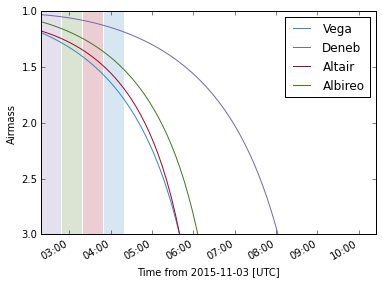

In [12]:
ts = start_time + np.linspace(0, (end_time-start_time).value, 100)*u.day
targ_to_color = {}
for target, c in zip(targets, color_cycle):
    plots.plot_airmass(target, pal, ts, style_kwargs=dict(color=c))
    targ_to_color[target.name] = c
plt.legend(loc=0)

for block in schedule:
    if hasattr(block, 'target'):
        plt.axvspan(block.start_time.plot_date, block.end_time.plot_date, 
                    fc=targ_to_color[block.target.name], lw=0, alpha=.2)
ax=plt.gca()